
### Part 1 Extract, transform, load, snow pit and transect data
[Josh King](https://github.com/kingjml), *CPS/CRD/ECCC*, 2021

This notebook provides data extraction, transformation and loading procedures for field data collected during the 2018-2019 TVCSnow campaign. The full dataset contains measurements which exceed the discussed material within this paper (e.g. 3 observation periods, where as only 1 is discussed in text).

Data at all sites (both static and roving) comes from 4 sources which are imported and prepared for analysis. We create reference SSA and density profiles from the imported snow pit and IceCube data. All data are UTM8N georefereced (EPSG 32608). Finalized datasets are exported to be used in further analysis steps. Second, we generate products to represent the snowpack at each site for further analysis and modeling. Imported snow pits are in the standard ECCC format and are read with the [snow pit parser](https://github.com/kingjml/tvc-snowpit-parser) developed along with [Mike Brady](https://github.com/m9brady).


Output of the workbook are science ready snow products for the TVC domain in pickle format.


In [1]:
# Establish path from notebook
import sys
sys.path.append("..")

# Community imports
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
from shapely.geometry import mapping
from shapely.wkt import loads as wkt_load

# Plot imports and settings
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

# ECCC imports
import constants
import tvcfunc
from snowpit_datasheet_parser import SnowPitSheet

# Paths to external files and constants
ext_file_list = [constants.VEG_TYPE_FILE, constants.VEG_HEIGHT_FILE, constants.DTM_ELV_FILE, constants.DTM_SLOPE_FILE]
ext_file_var = ['veg_type', 'veg_height', 'dtm_elv', 'dtm_slope']
site_dirs = Path(r'Data/Site')

ModuleNotFoundError: No module named 'rasterio'

## Crawl site directories and match data sources

This section crawls our field data and generates metadata. Input has been structured into site folders. The following datasets are evaluated:

1. **mp_files** - Magnaprobe Snow Depth - ECCC Standardized Excel Format
2. **pit_files** - Standard Snow Pits - ECCC Standardized Excel Format
3. **ssa_files** - IceCube SSA - ECCC Standardized Excel Format
4. **pnt_files** -  SnowMicroPen Penetration Force - SLF PNT Format

Output is a validated list of field datasets available for each site.

In [2]:
site_meta = tvcfunc.gen_site_meta(site_dirs)
site_meta.head()

,site,pnt_files,smp_meta,pit_files,ssa_files,mp_files
0,RS01,"[..\Data\Site\RS01\S34M2527.pnt, ..\Data\Site\...",[..\Data\Site\RS01\SMP_131118_RS01.csv],[..\Data\Site\RS01\PIT_131118_RS01.xlsx],[..\Data\Site\RS01\SSA_131118_RS01.csv],[..\Data\Site\RS01\MP_131118_RS01.xlsx]
1,RS02,"[..\Data\Site\RS02\S34M2546.pnt, ..\Data\Site\...",[..\Data\Site\RS02\SMP_131118_RS02.csv],[..\Data\Site\RS02\PIT_131118_RS02.xlsx],[..\Data\Site\RS02\SSA_131118_RS02.csv],[..\Data\Site\RS02\MP_131118_RS02.xlsx]
2,RS03,"[..\Data\Site\RS03\S34M2622.pnt, ..\Data\Site\...",[..\Data\Site\RS03\SMP_141118_RS03.csv],[..\Data\Site\RS03\PIT_141118_RS03.xlsx],[..\Data\Site\RS03\SSA_141118_RS03.csv],[..\Data\Site\RS03\MP_141118_RS03.xlsx]
3,RS04,"[..\Data\Site\RS04\S34M2640.pnt, ..\Data\Site\...",[..\Data\Site\RS04\SMP_141118_RS04.csv],[..\Data\Site\RS04\PIT_141118_RS04.xlsx],[..\Data\Site\RS04\SSA_141118_RS04.csv],[..\Data\Site\RS04\MP_141118_RP04.xlsx]
4,RS05,"[..\Data\Site\RS05\S34M2660.pnt, ..\Data\Site\...",[..\Data\Site\RS05\SMP_151118_RS05.csv],[..\Data\Site\RS05\PIT_151118_RS05.xlsx],[..\Data\Site\RS05\SSA_151118_RS05.csv],[..\Data\Site\RS05\MP_151118_RS05.xlsx]


# ETL snow pit reference data
This section loads all of the snow pit sheets and pulls meta data to create geospatial dataframe projected in UTM8N.

I then extract the density, ssa, and temperature profiles from each snow pit to generate and validate reference datasets. Each profile includes the associated grain type as well as relative height from the air-snow interface. Temperature profiles include tagging for the media type of the measurement.

I use the [SnowPitSheet library](https://github.com/kingjml/tvc-snowpit-parser) to read in our ECCC CPS style pit sheets. QA level metadata are provided in pit_meta.

In [3]:
# Load the snow pit data and create a geospatial dataframe
pit_files = site_meta['pit_files'].map(lambda x: x[0]).values
pit_data = [SnowPitSheet(pit) for pit in pit_files]
pit_df = [pd.DataFrame.from_dict(pit.meta, orient='index').transpose() for pit in pit_data]
pit_df = pd.concat(pit_df, axis=0)
pit_df['file_path'] = pit_files
pit_gdf = gpd.GeoDataFrame(data=pit_df.drop('geometry', axis=1), 
                           geometry=pit_df['geometry'].apply(wkt_load), 
                           crs=constants.CRS_WGS84)

pit_meta = pit_gdf.to_crs(constants.CRS_UTM8N).reset_index(drop=True)
pit_meta['timestamp'] = pd.to_datetime(pit_meta['timestamp']) 
pit_meta['site'] =pit_meta['pit_id'].str.replace('RP', 'RS', regex=True)

# Tag the campaign
pit_meta.loc[pit_meta['site'].isin(constants.TVC01), 'campaign'] = 'TVC01'
pit_meta.loc[pit_meta['site'].isin(constants.TVC02), 'campaign'] = 'TVC02'
pit_meta.loc[pit_meta['site'].isin(constants.TVC03), 'campaign'] = 'TVC03'
pit_meta.head(2)

,location,timestamp,surveyors,site,pit_id,slope,total_depth,utm_zone,comments,weather,...,wind_1,wind_2,ground_condition,soil_moisture,ground_roughness,ground_vegetation,tree_canopy,file_path,geometry,campaign
0,TVC 2018,2018-11-13 09:48:00,"Josh, Ben",RS01,RP01,Flat,34.5,8N,Comments/Notes/Indicate co-located measurements:,First roving site. Located at site waypoint #....,...,None,None,None,None,None,{},None,..\Data\Site\RS01\PIT_131118_RS01.xlsx,POINT (561402.426 7627347.290),TVC01
1,TVC 2018,2018-11-13 11:53:00,"Josh, Ben",RS02,RP02,Flat,28.0,8N,Comments/Notes/Indicate co-located measurements:,"Located on a plateau. AT = -23, winds at 3 m/s...",...,None,None,None,None,None,{},None,..\Data\Site\RS02\PIT_131118_RS02.xlsx,POINT (560862.323 7627725.511),TVC01


In [4]:
# Create reference density, SSA and temperature  profiles for each site
ref_rho = pd.DataFrame(); ref_ssa = pd.DataFrame(); ref_temp = pd.DataFrame()
for s_dix, s_meta in site_meta.iterrows():  
    pit_path = s_meta['pit_files'][0] # Only 1 pit per site for TVC
    ssa_path = s_meta['ssa_files'][0] # TODO: deal with multiple SSA files
    ref_rho = ref_rho.append(tvcfunc.load_ref_rho(pit_path).assign(site = s_meta['site']), ignore_index = True)
    ref_ssa = ref_ssa.append(tvcfunc.load_ref_ssa(ssa_path, pit_path).assign(site = s_meta['site']), ignore_index = True)
    ref_temp = ref_temp.append(tvcfunc.load_ref_temperature(pit_path).assign(site = s_meta['site']), ignore_index = True)

# Example snow pit data
The next two plots show observed density and SSA at (1) a single location and (2) for all snow pits

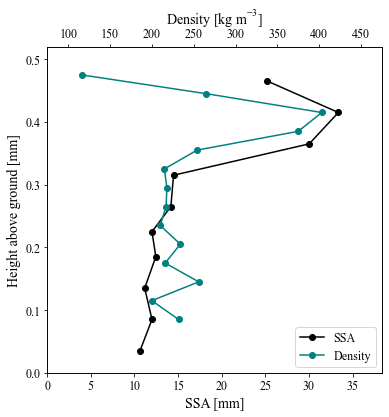

In [26]:
# Example snowpit of reference information
site_select = 'SM02'
dens = ref_rho.loc[ref_rho['site'] == site_select]
ssa = ref_ssa.loc[ref_ssa['site'] == site_select]
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twiny()
lns1 = ax1.plot(ssa['ssa'], ssa['height']/1000, marker = 'o', color = 'k', label = 'SSA')
lns2 = ax2.plot(dens['density'], dens['height']/1000, marker = 'o', color = 'teal', label = 'Density')
ax1.set_xlim(0,ssa['ssa'].max()+5)
ax1.set_ylim(0, ssa['height'].max()/1000 + 0.055)
ax2.set_xlim(75,dens['height'].max())
ax1.set_xlabel('SSA [mm]')
ax1.set_ylabel('Height above ground [mm]')
ax2.set_xlabel('Density [kg m$\mathregular{^{-3}}$]')

# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=4, fontsize=12)

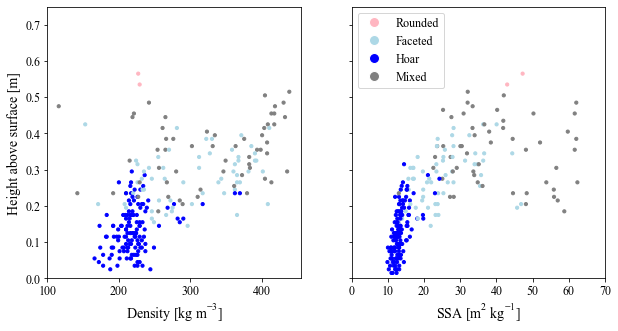

In [31]:
# Limit data to only January campaign
ref_rho_tvc2 = ref_rho[ref_rho['site'].isin(constants.TVC02)]
ref_ssa_tvc2 = ref_ssa[ref_ssa['site'].isin(constants.TVC02)]

# Layer colours based on international classification of snow
colors = {'N':'#969696', 'F':'#ADD8E6', 'H':'#0000FF', 'R':'#FFB6C1', 'M':'grey'}

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.scatter(ref_rho_tvc2['density'],ref_rho_tvc2['height']/1000, s = 10, alpha = 1, c=ref_rho_tvc2['grain_type'].map(colors))
ax2.scatter(ref_ssa_tvc2['ssa'],ref_ssa_tvc2['height']/1000, s = 10, alpha = 1, c=ref_ssa_tvc2['grain_type'].map(colors))
ax2.set_xlim(0, 70)
ax2.set_ylim(0, 0.75)
ax2.set_xlabel('SSA [m$\mathregular{^2}$ kg$\mathregular{^{-1}}$]')
ax1.set_ylabel('Height above surface [m]')
ax1.set_xlabel('Density [kg m$\mathregular{^{-3}}$]')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Rounded',
                          markerfacecolor='#FFB6C1', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Faceted',
                          markerfacecolor='#ADD8E6', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Hoar',
                          markerfacecolor='#0000FF', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Mixed',
                          markerfacecolor='grey', markersize=10)]
ax2.legend(handles=legend_elements, fontsize=12)



In [28]:
ref_ssa_tvc2.groupby('grain_type')['ssa'].describe()

,count,mean,std,min,25%,50%,75%,max
grain_type,,,,,,,,
F,59.0,25.180908,8.250971,12.911707,18.891815,23.762626,28.141087,46.787239
H,133.0,13.374954,2.221366,9.901494,12.098719,13.067053,13.944551,24.251712
M,54.0,40.384020,13.607262,13.037687,30.130222,36.398524,51.564161,72.452065
R,2.0,45.078542,3.012478,42.948398,44.013470,45.078542,46.143613,47.208685


In [29]:
ref_rho_tvc2.groupby('grain_type')['density'].describe()

,count,mean,std,min,25%,50%,75%,max
grain_type,,,,,,,,
F,58.0,301.413788,65.989906,153.0,246.00,299.0,364.25,410.0
H,128.0,220.632812,29.218920,166.0,208.75,218.0,229.00,369.0
M,57.0,325.333344,81.980911,116.0,265.00,334.0,403.00,438.0
R,2.0,228.000000,1.414214,227.0,227.50,228.0,228.50,229.0


# Magnaprobe snow depth data
ETL for ECCC standard magnaprobe files to a generate geospatial dataframe

In [32]:
# Load the magnaprobe data and create a geospatial dataframe
mp_data = pd.DataFrame()
mp_files = site_meta['mp_files'].map(lambda x: x[0]).values
mp_data = [pd.read_excel(mp).assign(site = site) for site, mp in zip(site_meta['site'].values, mp_files)]
mp_data = pd.concat(mp_data, axis=0)
mp_data = mp_data.drop(columns=['Counter','Unit'])
mp_data.columns = ['timestamp', 'depth', 'lat', 'lon', 'site']
mp_data = mp_data.loc[(mp_data['depth'] > 1 )| (mp_data['depth'] < 119)] # Drop marker measurements

mp_gdf = gpd.GeoDataFrame(mp_data, 
                          geometry=gpd.points_from_xy(mp_data.lon, mp_data.lat), 
                          crs = constants.CRS_WGS84)
mp_utm = mp_gdf.to_crs(constants.CRS_UTM8N)

mp_utm.loc[mp_utm['site'].isin(constants.TVC01), 'campaign'] = 'TVC01'
mp_utm.loc[mp_utm['site'].isin(constants.TVC02), 'campaign'] = 'TVC02'
mp_utm.loc[mp_utm['site'].isin(constants.TVC03), 'campaign'] = 'TVC03'

# This flags instances where the Magnaprobe RTC battery failed
time_fix, rtc_fail = tvcfunc.rtc_check_mp(mp_utm['timestamp'])
mp_utm = mp_utm.assign(timestamp = time_fix, rtc_fail = rtc_fail)

The next two plots show (1) the seasonal distrobutions of snows depth across all sites and (2) locations of the snow depths seperated by campaign.

,count,mean,std,min,25%,50%,75%,max
campaign,,,,,,,,
TVC01,6185.0,34.019688,9.535905,0.007,28.080,33.15,38.8500,120.2
TVC02,6708.0,46.696394,13.213402,12.950,38.010,45.61,54.2125,115.4
TVC03,8331.0,43.795541,14.033336,8.250,33.995,42.48,51.8800,119.5


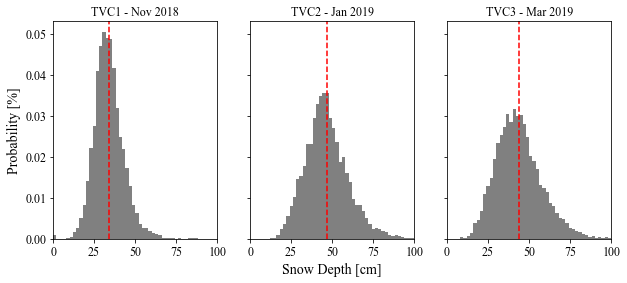

In [33]:
bins = np.arange(0,120, 2)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,4))
ax1.hist(mp_utm.loc[mp_utm['campaign'] == 'TVC01']['depth'].values, 
         density=True, bins=bins, label = 'TVC-1', color = 'GREY')
ax2.hist(mp_utm.loc[mp_utm['campaign'] == 'TVC02']['depth'].values, 
         density=True, bins=bins, label = 'TVC-2', color = 'GREY') 
ax3.hist(mp_utm.loc[mp_utm['campaign'] == 'TVC03']['depth'].values, 
         density=True, bins=bins, label = 'TVC-3', color = 'GREY') 

ax1.set_title('TVC1 - Nov 2018')
ax2.set_title('TVC2 - Jan 2019')
ax3.set_title('TVC3 - Mar 2019')
ax2.set_xlabel('Snow Depth [cm]')
ax1.set_ylabel('Probability [%]')


mean_1 = mp_utm.loc[mp_utm['campaign'] == 'TVC01']['depth'].mean()
mean_2 = mp_utm.loc[mp_utm['campaign'] == 'TVC02']['depth'].mean()
mean_3 = mp_utm.loc[mp_utm['campaign'] == 'TVC03']['depth'].mean()

ax1.axvline(x=mean_1, color='r', linestyle='--')
ax2.axvline(x=mean_2, color='r', linestyle='--')
ax3.axvline(x=mean_3, color='r', linestyle='--')

ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
ax3.set_xlim(0,100)

f.savefig('../Output/Figures/site_magnaprobe_depth.jpg', dpi = 300)

mp_utm.groupby('campaign')['depth'].describe()

# Compute summary site statistics
We match sites with the magnaprobe data to compute summary statistics. Distance between the magnaprobe points and the snow pit are also calculated to make sure we are on target. We then take the reference SSA, density, and temperature datasets to generate layer weighted averages.

In [35]:
snow_stats = pd.DataFrame()
for idx, pit in pit_meta.iterrows():
    mp_local = mp_utm.loc[mp_utm['site'] == pit['site']]
    pit_local = gpd.GeoSeries(pit.geometry, crs = constants.CRS_UTM8N)
    dist_to_pit = mp_local.geometry.apply(lambda g: pit_local.distance(g))
    
    snow_stats = snow_stats.append(({'site': pit['site'],
                  'depth_count': mp_local['depth'].count(),
                  'depth_mean': mp_local['depth'].mean(), 
                  'depth_median': mp_local['depth'].median(),
                  'depth_std': mp_local['depth'].std(),
                  'dist_max': dist_to_pit.max()[0],
                  'dist_min': dist_to_pit.min()[0],
                  'dist_mean': dist_to_pit.mean()[0]}),ignore_index=True)

# Get weighted mean of each site density ssa and temperature profile
for site in snow_stats['site'].unique():
    l_ssa = ref_ssa.loc[ref_ssa['site'] == site]['ssa'].values
    l_thickness_ssa = np.abs(np.diff(np.append(ref_ssa.loc[ref_ssa['site'] == site]['height'].values, 0)))
    snow_stats.loc[snow_stats['site'] == site, 'ssa_mean'] = np.average(l_ssa, weights = l_thickness_ssa)
    snow_stats.loc[snow_stats['site'] == site, 'ssa_count'] = len(l_thickness_ssa)
    
    l_dens = ref_rho.loc[ref_rho['site'] == site]['density'].values
    l_thickness_dens = np.abs(np.diff(np.append(ref_rho.loc[ref_rho['site'] == site]['height'].values, 0)))
    snow_stats.loc[snow_stats['site'] == site, 'dens_mean'] = np.average(l_dens, weights = l_thickness_dens)
    snow_stats.loc[snow_stats['site'] == site, 'dens_count'] = len(l_thickness_dens)
    
    # Limit to measurements in snow only
    ref_temp_snow = ref_temp.loc[(ref_temp['site'] == site) & (ref_temp['type'] == 'snow')]
    l_temp = ref_temp_snow['temperature_k'].values
    l_thickness_temp = np.abs(np.diff(np.append(ref_temp_snow['height'].values, 0)))
    snow_stats.loc[snow_stats['site'] == site, 'temp_mean'] = np.average(l_temp, weights = l_thickness_temp)
snow_stats['swe_mean'] = snow_stats['depth_mean']/100 * snow_stats['dens_mean']

snow_stats.head(5)

,site,depth_count,depth_mean,depth_median,depth_std,dist_max,dist_min,dist_mean,ssa_mean,ssa_count,dens_mean,dens_count,temp_mean,swe_mean
0,RS01,348.0,34.703563,33.765,7.216446,228.342479,4.151556,83.327945,19.821297,6.0,198.923077,10.0,258.716660,69.033396
1,RS02,288.0,35.326840,34.390,8.756437,157.222222,1.597891,68.399205,17.792863,5.0,171.207547,8.0,259.609988,60.482217
2,RS03,249.0,35.454819,34.530,8.763020,162.440222,2.861935,71.542305,21.571987,7.0,206.333333,9.0,262.199997,73.155110
3,RS04,249.0,32.437510,31.420,7.040102,182.928065,0.983085,78.184670,23.773703,6.0,189.945455,8.0,260.189999,61.613576
4,RS05,280.0,36.698964,36.095,8.458829,172.568529,2.032063,70.086874,18.298919,6.0,195.764706,8.0,258.889999,71.843619


# Extract information from external datasets
For each site we extract terrain and vegetation information at each site from:

- [Grünberg and Boike (2019). Vegetation map of Trail Valley Creek](https://doi.pangaea.de/10.1594/PANGAEA.904270)
- [Anders, et al. (2018). Airborne Laser Scanning (ALS) Point Clouds of Trail Valley Creek)](https://doi.pangaea.de/10.1594/PANGAEA.894884)

The resulting dataset contains numpy masked arrays of veg height, veg type, and surface elevation for all grid cells within 50 m of all sites. 

Then generate summary statistics for each site with output variables (*aux_stats*):

- **site**: ECCC site names
- **pit_ts**: Timestamp of snow pit
- **veg_c_per**: Percentage coverage of each veg class in constants.VEG_CLASS
- **veg_h_mean**: Mean veg height
- **veg_h_std**: Standard dev of veg height
- **dem_h_mean**: Mean DEM height
- **dem_h_std**: Standard dev of DEM height

In [38]:
pit_ext = pd.concat([pit_meta,pd.DataFrame(columns=ext_file_var)])
for site_idx, site in pit_meta.iterrows():
    buffer = site.geometry.buffer(constants.SITE_BUFFER)
    for var_idx, ext_file in enumerate(ext_file_list):
        with rasterio.open(ext_file, "r+") as src:
            out_image, out_transform = rasterio.mask.mask(src, [mapping(buffer)], crop=True)
            out_image = np.ma.masked_where((out_image == -9999)|(out_image == 9999), out_image)
            pit_ext.iat[site_idx, pit_ext.columns.get_loc(ext_file_var[var_idx])] = out_image[0]

In [44]:
# Extract the veg and dem metrics
# TODO: Add masked gradient for slope
aux_stats = pd.DataFrame()
for idx, pit in pit_ext.iterrows():
    veg_cover = [0] * len(constants.VEG_CLASS)
    veg_ext = pit['veg_type'][pit['veg_type'].mask == False].data
    (veg_type, veg_count) = np.unique(veg_ext, return_counts=True)
    veg_per = (veg_count/veg_count.sum())*100
    for i,vtype in enumerate(veg_type):
        veg_cover[vtype] = veg_per[i]

    veg_h_mean = pit['veg_height'].mean()
    veg_h_std = pit['veg_height'].std()

    dem_h_mean = pit['dtm_elv'].mean()
    dem_h_std = pit['dtm_elv'].std()
    
    dem_s_mean = pit['dtm_slope'].mean()
    dem_s_std = pit['dtm_slope'].std()
    
    aux_stats = aux_stats.append(({'site': pit['site'],
                                   'pit_ts': pit['timestamp'],
                                   'veg_c_per': veg_cover,
                                   'veg_h_mean': veg_h_mean,
                                   'veg_h_std': veg_h_std, 
                                   'dem_h_mean': dem_h_mean,
                                   'dem_h_std': dem_h_std,
                                   'dem_s_mean': dem_s_mean,
                                   'dem_s_std': dem_s_std}),ignore_index=True)
# Merge the aux and snow stats for each site
pit_stats = pd.merge(aux_stats, snow_stats, on='site')
pit_stats.to_csv("../Output/Data/pit_stats.csv")

In [89]:
# Get average site composition
cum_cov = [sum(x) for x in zip(*pit_stats['veg_c_per'].values)]
cum_elm = len(pit_stats['veg_c_per'])
avg_cov = [i / cum_elm for i in cum_cov]
print(constants.VEG_CLASS)
print(avg_cov)

['Tree', 'Tall Shrub', 'Riparian Shrub', 'Dwarf Shrub', 'Tussock', 'Lichen', 'Water']
[0.0, 1.7436472040902422, 1.9122617185020028, 30.61774248485885, 39.115508227600166, 26.610840364948743, 0.0]


Site RS26
Mean MP Snow (cm): 41.8
Weighted Cutter Dens.: 227.7
Mean SWE (mm): 95.11
Mean IC SSA: 15.1
Mean Veg. Height: 0.032 m

Tree: 0%
Tall Shrub: 0%
Riparian Shrub: 0%
Dwarf Shrub: 12.5%
Tussock: 78.8%
Lichen: 8.8%
Water: 0%


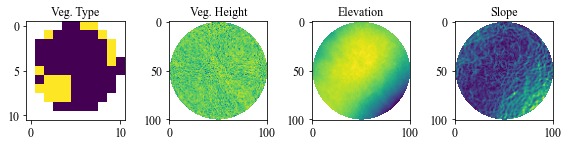

In [66]:
# Example of the extracted data
site_name = 'RS26'
site_analysis = pit_ext[pit_ext['site'].str.contains(site_name)]
site_aux = aux_stats[aux_stats['site'].str.contains(site_name)]
site_snow = snow_stats[snow_stats['site'].str.contains(site_name)]
print('Site {}'.format(site_name))
print('Mean MP Snow (cm): {:.3}'.format(site_snow['depth_mean'].values[0]))
print('Weighted Cutter Dens.: {:.4}'.format(site_snow['dens_mean'].values[0]))
print('Mean SWE (mm): {:.4}'.format(site_snow['swe_mean'].values[0]))
print('Mean IC SSA: {:.3}'.format(site_snow['ssa_mean'].values[0]))
print('Mean Veg. Height: {:.2} m\n'.format(site_aux['veg_h_mean'].values[0]))
for vi, vc in enumerate(constants.VEG_CLASS):
    print('{}: {}%'.format(vc, np.round(site_pit['veg_c_per'].values[0][vi],1)))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8, 8))
ax1.imshow(site_analysis['veg_type'].values[0])
ax2.imshow(np.log(site_analysis['veg_height'].values[0]* 200))
ax3.imshow(site_analysis['dtm_elv'].values[0])
ax4.imshow(site_analysis['dtm_slope'].values[0])

ax1.set_title('Veg. Type')
ax2.set_title('Veg. Height')
ax3.set_title('Elevation')
ax4.set_title('Slope')
fig.tight_layout()

# Save the processed field datasets

In [41]:
site_meta.to_pickle("../Output/Data/site_meta.pkl")
ref_ssa.to_pickle("../Output/Data/ref_ssa.pkl")
ref_rho.to_pickle("../Output/Data/ref_rho.pkl")
ref_temp.to_pickle("../Output/Data/ref_temp.pkl")
mp_utm.to_pickle("../Output/Data/ref_mp.pkl")
pit_meta.to_pickle("../Output/Data/ref_pit.pkl")
pit_stats.to_pickle("../Output/Data/pit_stats.pkl")
pit_ext.to_pickle("../Output/Data/pit_aux.pkl")